In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [2]:
# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    # scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

def selu_forward(X):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
    cache = X
    return out, cache

def selu_backward(dout, cache):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    X = cache
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
    return dX

# p_dropout = keep_prob
def selu_dropout_forward(h, q):
    '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    alpha_p = -scale * alpha
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = (mask * h) + ((1 - mask) * alpha_p)
    a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
    b = -a * (1 - q) * alpha_p
    out = (a * dropped) + b
    cache = (a, mask)
    return out, cache

def selu_dropout_backward(dout, cache):
    a, mask = cache
    d_dropped = dout * a
    dh = d_dropped * mask
    return dh

X_train, X_val, X_test = prepro(X_train, X_val, X_test)

In [3]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L, p_dropout):
#         self.mode = 'classification'
        self.L = L # number of layers or depth
#         self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        
        # Input layer
        m = dict(W=np.random.randn(D, H) / np.sqrt(D / 2.),
                 b=np.zeros((1, H)))
        self.model.append(m)

        # Hidden layers
        m = dict(W=np.random.randn(H, H) / np.sqrt(H / 2.),
                 b=np.zeros((1, H)))
        m_L = []
        for _ in range(L):
            m_L.append(m)
        self.model.append(m_L)
        
        # Output layer
        m = dict(W=np.random.randn(H, C) / np.sqrt(H / 2.),
                 b=np.zeros((1, C)))
        self.model.append(m)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, h = cache

        dW = h.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
#         print('db.shape', db.shape)
        dX = dout @ W.T # Backprop

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = selu_forward(X=y)
        X = y.copy() # pass the previous output to the next layer
        caches.append((fc_cache, nl_cache)) # caches[0]
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = selu_forward(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
            nl_caches.append(nl_cache)
        caches.append((fc_caches, nl_caches)) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
    
    def train_backward(self, dy, caches):
#         grads = self.model.copy()
#         print('dy.shape', dy.shape)
        grads = []

        # Input layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        # Hidden layer
        grad = []
        for layer in range(self.L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        grads.append(grad)

        # Outout layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Input layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy = dX.copy() # pass it to the previous layer
        grads[2]['W'] = dW
        grads[2]['b'] = db
#         print('''grads[2]['W'].shape, grads[2]['b'].shape''', grads[2]['W'].shape, grads[2]['b'].shape)

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = selu_backward(dout=dy, cache=nl_caches[layer])
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
#             print('''grads[1][]layer['W'].shape, grads[1][layer]['b'].shape''', grads[1][layer]['W'].shape, 
#                   grads[1][layer]['b'].shape)

        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = selu_backward(dout=dy, cache=nl_cache)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db
#         print('''grads[0]['W'].shape, grads[0]['b'].shape''', grads[0]['W'].shape, grads[0]['b'].shape)

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Momentums
        M, R = [], []

        # Input layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers momentum
        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        # Output layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
 
        # Learning decay
        beta1 = .9
        beta2 = .99
        smooth_train = 1.

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            # Shuffle in every iteration
            # The dataset is static and non-sequentiol: no time-dependency or temporal pattern
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]
#                 M[0][key] = l.exp_running_avg(M[0][key], grads[0][key], beta1)
#                 R[0][key] = l.exp_running_avg(R[0][key], grads[0][key]**2, beta2)
#                 m_k_hat = M[0][key] / (1. - (beta1**(iter)))
#                 r_k_hat = R[0][key] / (1. - (beta2**(iter)))
#                 self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]
#                     M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grads[1][layer][key], beta1)
#                     R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grads[1][layer][key]**2, beta2)
#                     m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
#                     r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))
#                     self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)


            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
#                 M[2][key] = l.exp_running_avg(M[2][key], grads[2][key], beta1)
#                 R[2][key] = l.exp_running_avg(R[2][key], grads[2][key]**2, beta2)
#                 m_k_hat = M[2][key] / (1. - (beta1**(iter)))
#                 r_k_hat = R[2][key] / (1. - (beta2**(iter)))
#                 self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)


            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [4]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# NOT used now
p_dropout = 0.95 #  layer & unit noise: keep_prob = p_dropout, q = 1-p, 0.95 or 0.90 by default, noise at the network level or layers


# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

nn.adam(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.5032 valid loss: 2.5223, valid accuracy: 0.1218
Iter-20 train loss: 2.5962 valid loss: 2.4542, valid accuracy: 0.1256
Iter-30 train loss: 2.3379 valid loss: 2.3940, valid accuracy: 0.1378
Iter-40 train loss: 2.4953 valid loss: 2.3422, valid accuracy: 0.1484
Iter-50 train loss: 2.4086 valid loss: 2.2920, valid accuracy: 0.1588
Iter-60 train loss: 2.2327 valid loss: 2.2482, valid accuracy: 0.1724
Iter-70 train loss: 2.2144 valid loss: 2.2045, valid accuracy: 0.1872
Iter-80 train loss: 2.2398 valid loss: 2.1645, valid accuracy: 0.1982
Iter-90 train loss: 2.0804 valid loss: 2.1245, valid accuracy: 0.2180
Iter-100 train loss: 2.0258 valid loss: 2.0839, valid accuracy: 0.2326
Iter-110 train loss: 2.0534 valid loss: 2.0442, valid accuracy: 0.2528
Iter-120 train loss: 1.9820 valid loss: 2.0092, valid accuracy: 0.2712
Iter-130 train loss: 1.9396 valid loss: 1.9767, valid accuracy: 0.2870
Iter-140 train loss: 1.9860 valid loss: 1.9411, valid accuracy: 0.3106
Iter-150 train 

Iter-1170 train loss: 0.8112 valid loss: 0.8474, valid accuracy: 0.7788
Iter-1180 train loss: 0.8282 valid loss: 0.8439, valid accuracy: 0.7798
Iter-1190 train loss: 0.9695 valid loss: 0.8405, valid accuracy: 0.7822
Iter-1200 train loss: 0.8464 valid loss: 0.8373, valid accuracy: 0.7836
Iter-1210 train loss: 0.7477 valid loss: 0.8338, valid accuracy: 0.7826
Iter-1220 train loss: 0.9184 valid loss: 0.8304, valid accuracy: 0.7830
Iter-1230 train loss: 0.8695 valid loss: 0.8268, valid accuracy: 0.7852
Iter-1240 train loss: 0.7705 valid loss: 0.8231, valid accuracy: 0.7860
Iter-1250 train loss: 1.1348 valid loss: 0.8200, valid accuracy: 0.7874
Iter-1260 train loss: 0.7927 valid loss: 0.8171, valid accuracy: 0.7856
Iter-1270 train loss: 0.8614 valid loss: 0.8137, valid accuracy: 0.7886
Iter-1280 train loss: 0.8899 valid loss: 0.8106, valid accuracy: 0.7900
Iter-1290 train loss: 0.6292 valid loss: 0.8074, valid accuracy: 0.7896
Iter-1300 train loss: 0.8841 valid loss: 0.8044, valid accuracy:

Iter-2310 train loss: 0.4915 valid loss: 0.6103, valid accuracy: 0.8350
Iter-2320 train loss: 0.8936 valid loss: 0.6090, valid accuracy: 0.8344
Iter-2330 train loss: 0.5644 valid loss: 0.6079, valid accuracy: 0.8344
Iter-2340 train loss: 0.7758 valid loss: 0.6068, valid accuracy: 0.8342
Iter-2350 train loss: 0.6675 valid loss: 0.6056, valid accuracy: 0.8348
Iter-2360 train loss: 0.7106 valid loss: 0.6044, valid accuracy: 0.8356
Iter-2370 train loss: 0.8975 valid loss: 0.6033, valid accuracy: 0.8356
Iter-2380 train loss: 0.7189 valid loss: 0.6021, valid accuracy: 0.8362
Iter-2390 train loss: 0.6375 valid loss: 0.6010, valid accuracy: 0.8360
Iter-2400 train loss: 0.6479 valid loss: 0.5999, valid accuracy: 0.8364
Iter-2410 train loss: 0.5400 valid loss: 0.5986, valid accuracy: 0.8370
Iter-2420 train loss: 0.5539 valid loss: 0.5975, valid accuracy: 0.8366
Iter-2430 train loss: 0.5490 valid loss: 0.5962, valid accuracy: 0.8360
Iter-2440 train loss: 0.5780 valid loss: 0.5951, valid accuracy:

Iter-3450 train loss: 0.7826 valid loss: 0.5096, valid accuracy: 0.8594
Iter-3460 train loss: 0.5905 valid loss: 0.5090, valid accuracy: 0.8600
Iter-3470 train loss: 0.4373 valid loss: 0.5084, valid accuracy: 0.8600
Iter-3480 train loss: 0.7528 valid loss: 0.5077, valid accuracy: 0.8600
Iter-3490 train loss: 0.4836 valid loss: 0.5071, valid accuracy: 0.8600
Iter-3500 train loss: 0.3619 valid loss: 0.5066, valid accuracy: 0.8596
Iter-3510 train loss: 0.6947 valid loss: 0.5059, valid accuracy: 0.8600
Iter-3520 train loss: 0.6698 valid loss: 0.5059, valid accuracy: 0.8620
Iter-3530 train loss: 0.5298 valid loss: 0.5051, valid accuracy: 0.8614
Iter-3540 train loss: 0.5018 valid loss: 0.5045, valid accuracy: 0.8612
Iter-3550 train loss: 0.6266 valid loss: 0.5037, valid accuracy: 0.8608
Iter-3560 train loss: 0.4900 valid loss: 0.5032, valid accuracy: 0.8618
Iter-3570 train loss: 0.6083 valid loss: 0.5026, valid accuracy: 0.8624
Iter-3580 train loss: 0.5724 valid loss: 0.5019, valid accuracy:

Iter-4590 train loss: 0.3770 valid loss: 0.4536, valid accuracy: 0.8732
Iter-4600 train loss: 0.3704 valid loss: 0.4533, valid accuracy: 0.8730
Iter-4610 train loss: 0.5869 valid loss: 0.4527, valid accuracy: 0.8728
Iter-4620 train loss: 0.5228 valid loss: 0.4523, valid accuracy: 0.8732
Iter-4630 train loss: 0.5058 valid loss: 0.4517, valid accuracy: 0.8730
Iter-4640 train loss: 0.4050 valid loss: 0.4513, valid accuracy: 0.8728
Iter-4650 train loss: 0.3949 valid loss: 0.4509, valid accuracy: 0.8730
Iter-4660 train loss: 0.2986 valid loss: 0.4504, valid accuracy: 0.8730
Iter-4670 train loss: 0.3895 valid loss: 0.4500, valid accuracy: 0.8734
Iter-4680 train loss: 0.4508 valid loss: 0.4496, valid accuracy: 0.8730
Iter-4690 train loss: 0.4544 valid loss: 0.4492, valid accuracy: 0.8734
Iter-4700 train loss: 0.5522 valid loss: 0.4489, valid accuracy: 0.8730
Iter-4710 train loss: 0.3857 valid loss: 0.4486, valid accuracy: 0.8732
Iter-4720 train loss: 0.6644 valid loss: 0.4482, valid accuracy:

Iter-5730 train loss: 0.5561 valid loss: 0.4165, valid accuracy: 0.8816
Iter-5740 train loss: 0.4709 valid loss: 0.4163, valid accuracy: 0.8814
Iter-5750 train loss: 0.3521 valid loss: 0.4161, valid accuracy: 0.8810
Iter-5760 train loss: 0.4629 valid loss: 0.4158, valid accuracy: 0.8812
Iter-5770 train loss: 0.5420 valid loss: 0.4154, valid accuracy: 0.8820
Iter-5780 train loss: 0.4285 valid loss: 0.4153, valid accuracy: 0.8826
Iter-5790 train loss: 0.4117 valid loss: 0.4149, valid accuracy: 0.8820
Iter-5800 train loss: 0.4488 valid loss: 0.4147, valid accuracy: 0.8818
Iter-5810 train loss: 0.5024 valid loss: 0.4143, valid accuracy: 0.8824
Iter-5820 train loss: 0.3740 valid loss: 0.4142, valid accuracy: 0.8824
Iter-5830 train loss: 0.4294 valid loss: 0.4138, valid accuracy: 0.8824
Iter-5840 train loss: 0.3523 valid loss: 0.4135, valid accuracy: 0.8822
Iter-5850 train loss: 0.5115 valid loss: 0.4132, valid accuracy: 0.8824
Iter-5860 train loss: 0.2434 valid loss: 0.4129, valid accuracy:

Iter-6870 train loss: 0.5013 valid loss: 0.3898, valid accuracy: 0.8876
Iter-6880 train loss: 0.4082 valid loss: 0.3895, valid accuracy: 0.8878
Iter-6890 train loss: 0.4167 valid loss: 0.3892, valid accuracy: 0.8878
Iter-6900 train loss: 0.2891 valid loss: 0.3891, valid accuracy: 0.8882
Iter-6910 train loss: 0.3556 valid loss: 0.3889, valid accuracy: 0.8880
Iter-6920 train loss: 0.4019 valid loss: 0.3887, valid accuracy: 0.8882
Iter-6930 train loss: 0.6046 valid loss: 0.3885, valid accuracy: 0.8882
Iter-6940 train loss: 0.3395 valid loss: 0.3883, valid accuracy: 0.8882
Iter-6950 train loss: 0.3955 valid loss: 0.3880, valid accuracy: 0.8882
Iter-6960 train loss: 0.5226 valid loss: 0.3878, valid accuracy: 0.8878
Iter-6970 train loss: 0.3854 valid loss: 0.3877, valid accuracy: 0.8886
Iter-6980 train loss: 0.4216 valid loss: 0.3875, valid accuracy: 0.8882
Iter-6990 train loss: 0.3596 valid loss: 0.3873, valid accuracy: 0.8882
Iter-7000 train loss: 0.4081 valid loss: 0.3871, valid accuracy:

Iter-8010 train loss: 0.3479 valid loss: 0.3704, valid accuracy: 0.8926
Iter-8020 train loss: 0.3914 valid loss: 0.3700, valid accuracy: 0.8926
Iter-8030 train loss: 0.4018 valid loss: 0.3698, valid accuracy: 0.8924
Iter-8040 train loss: 0.3501 valid loss: 0.3695, valid accuracy: 0.8928
Iter-8050 train loss: 0.6034 valid loss: 0.3693, valid accuracy: 0.8924
Iter-8060 train loss: 0.1787 valid loss: 0.3692, valid accuracy: 0.8924
Iter-8070 train loss: 0.3149 valid loss: 0.3691, valid accuracy: 0.8930
Iter-8080 train loss: 0.3874 valid loss: 0.3687, valid accuracy: 0.8922
Iter-8090 train loss: 0.4706 valid loss: 0.3687, valid accuracy: 0.8932
Iter-8100 train loss: 0.2462 valid loss: 0.3685, valid accuracy: 0.8930
Iter-8110 train loss: 0.3032 valid loss: 0.3682, valid accuracy: 0.8930
Iter-8120 train loss: 0.3950 valid loss: 0.3679, valid accuracy: 0.8930
Iter-8130 train loss: 0.4295 valid loss: 0.3679, valid accuracy: 0.8932
Iter-8140 train loss: 0.6209 valid loss: 0.3677, valid accuracy:

Iter-9150 train loss: 0.2753 valid loss: 0.3543, valid accuracy: 0.8950
Iter-9160 train loss: 0.4371 valid loss: 0.3542, valid accuracy: 0.8950
Iter-9170 train loss: 0.2767 valid loss: 0.3542, valid accuracy: 0.8948
Iter-9180 train loss: 0.3693 valid loss: 0.3539, valid accuracy: 0.8954
Iter-9190 train loss: 0.5232 valid loss: 0.3538, valid accuracy: 0.8948
Iter-9200 train loss: 0.3563 valid loss: 0.3537, valid accuracy: 0.8958
Iter-9210 train loss: 0.2023 valid loss: 0.3537, valid accuracy: 0.8956
Iter-9220 train loss: 0.2396 valid loss: 0.3535, valid accuracy: 0.8960
Iter-9230 train loss: 0.2816 valid loss: 0.3534, valid accuracy: 0.8954
Iter-9240 train loss: 0.3500 valid loss: 0.3532, valid accuracy: 0.8954
Iter-9250 train loss: 0.2735 valid loss: 0.3531, valid accuracy: 0.8952
Iter-9260 train loss: 0.5177 valid loss: 0.3532, valid accuracy: 0.8956
Iter-9270 train loss: 0.3022 valid loss: 0.3532, valid accuracy: 0.8954
Iter-9280 train loss: 0.4968 valid loss: 0.3531, valid accuracy:

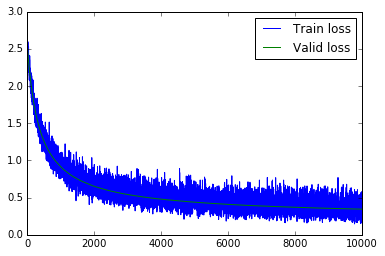

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

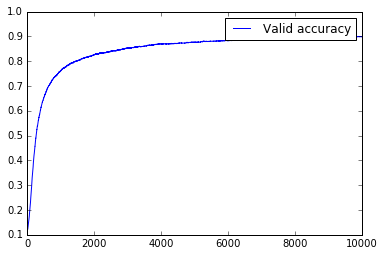

In [6]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()